![](https://drive.google.com/uc?id=1e5ZF3Jmap6S2EAM80GrftyBIWvsOqPcQ)

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

# **<span style="color:#F7B2B0;">Goal</span>**

The goal of this competition is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.

# **<span style="color:#F7B2B0;">Data</span>**


**Files**

`train.csv` -  Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

`test.csv` - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set. 

`sample_submission.csv` - a sample submission file in the correct format

**Columns**

`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name` - The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


# **<span style="color:#F7B2B0;">Evaluation Metric</span>**

Submissions are evaluated based on their classification accuracy, the percentage of predicted labels that are correct.

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67">

> I will be integrating W&B for visualizations and logging artifacts!
> 
> [Space Titanic project on W&B Dashboard](https://wandb.ai/usharengaraju/SpaceTitanic)
> 
> - To get the API key, create an account in the [website](https://wandb.ai/site) .
> - Use secrets to use API Keys more securely 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import missingno as msno
import shap

import wandb

from tensorflow.keras.layers import StringLookup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

#ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix,precision_recall_curve,precision_recall_curve,plot_precision_recall_curve

In [2]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("api_key")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
CONFIG = dict(competition = 'SpaceTitanic',_wandb_kernel = 'tensorgirl')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
df_train = pd.read_csv("../input/spaceship-titanic/train.csv")
df_test = pd.read_csv("../input/spaceship-titanic/test.csv")
NUMERIC_FEATURE_NAMES = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]

CATEGORICAL_FEATURE_NAMES1 = ["HomePlanet","CryoSleep","Destination","VIP"]

In [4]:
df_train.head().style.background_gradient(cmap="Pastel1")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,Willy Santantines,True


# **<span style="color:#F7B2B0;">Missing Values</span>**

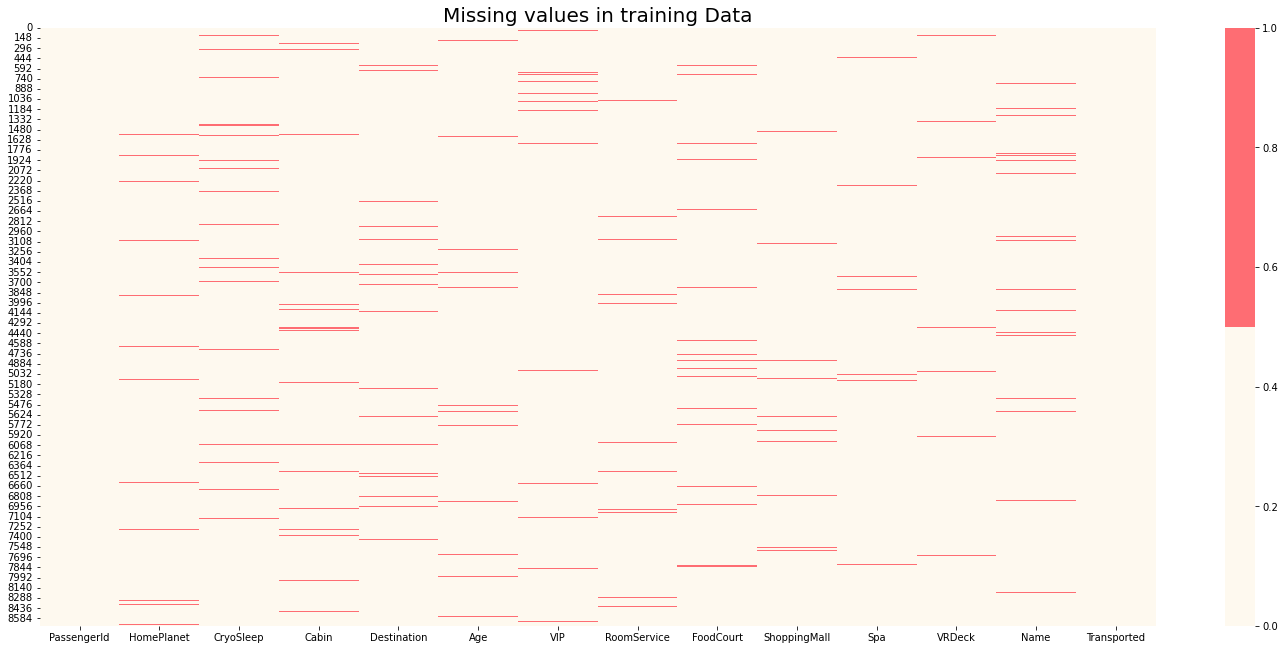

In [5]:
plt.figure(figsize = (25,11))
sns.heatmap(df_train.isna().values, cmap = ['#fef9ef','#fe6d73'], xticklabels=df_train.columns)
plt.title("Missing values in training Data", size=20);

In [6]:
missing_columns = [col for col in df_train.columns if df_train[col].isnull().any()]
missingvalues_count =df_train.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df .style.background_gradient(cmap="Pastel1")

,Null Values Count
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208
Spa,183


In [7]:
# basic stats of features
df_train.describe().style.background_gradient(cmap="Pastel1")

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


# **<span style="color:#F7B2B0;">Target variable distribution</span>**

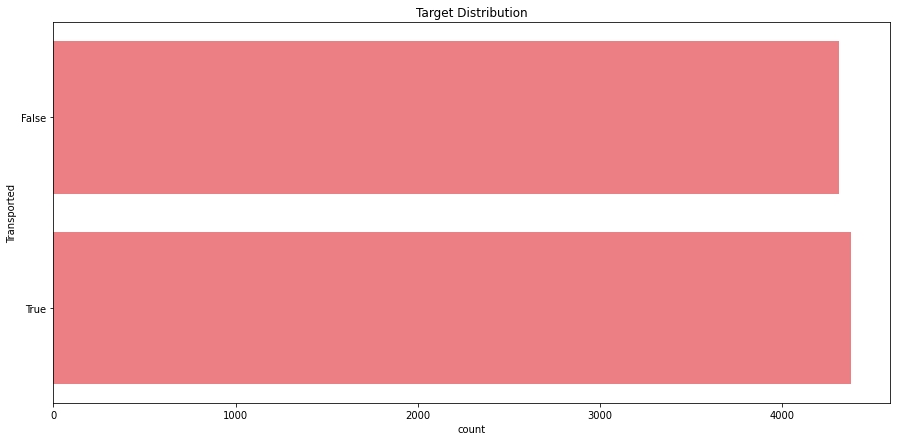

In [8]:
plt.figure(figsize = (15, 7))    
sns.countplot(y = df_train['Transported'], color = '#fe6d73')        
plt.title("Target Distribution")    
plt.show()

## **<span style="color:#e76f51;">Numerical Feature Distribution</span>**

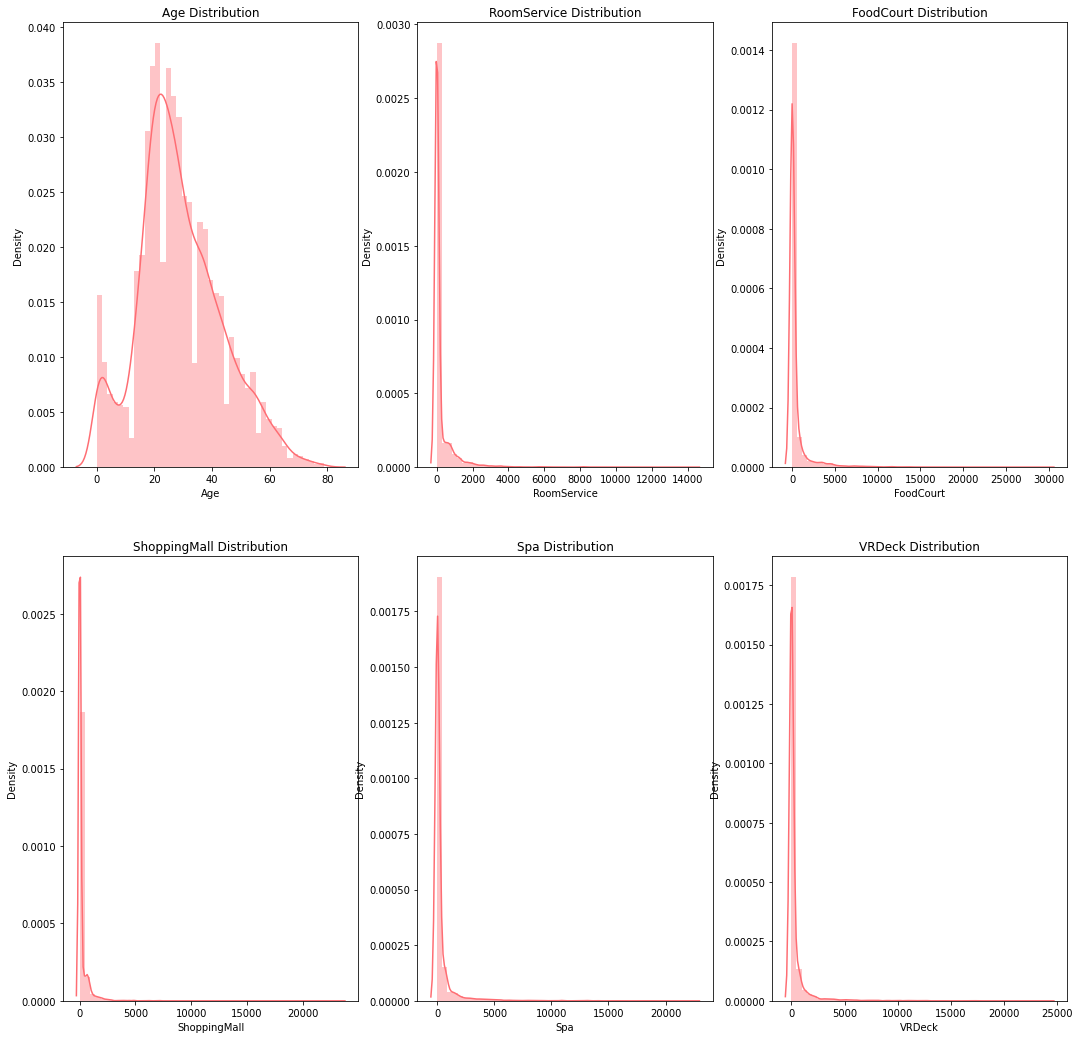

In [9]:
fig, ax = plt.subplots(2,3, figsize=(18, 18))
for i, feature in enumerate(NUMERIC_FEATURE_NAMES):
    sns.distplot(df_train[feature], color = '#fe6d73', ax=ax[math.floor(i/3),i%3]).set_title(f'{feature} Distribution')
fig.show()

## **<span style="color:#e76f51;">Categorical Feature Distribution</span>**

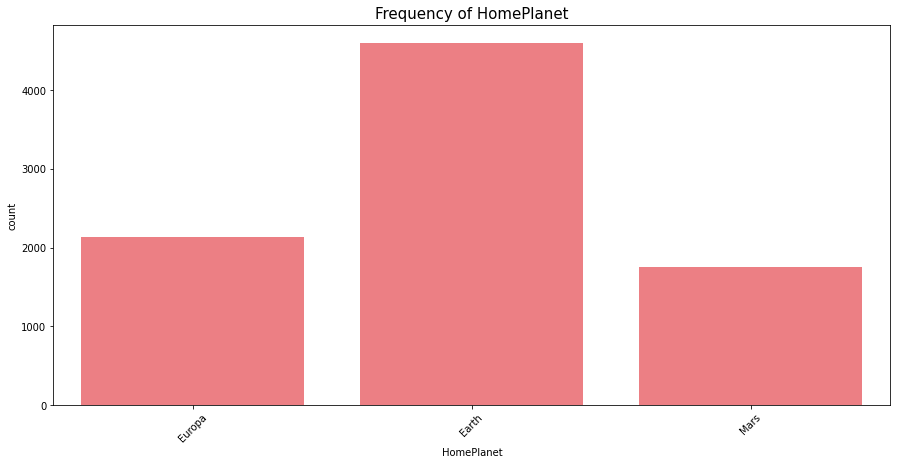

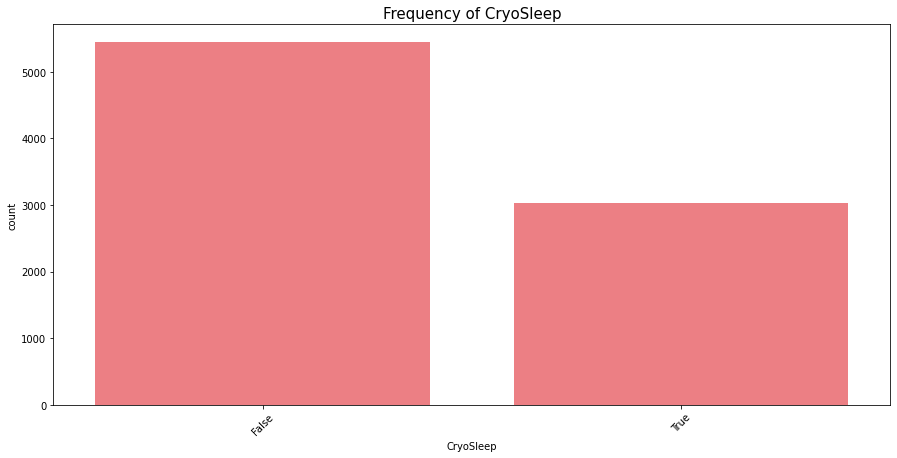

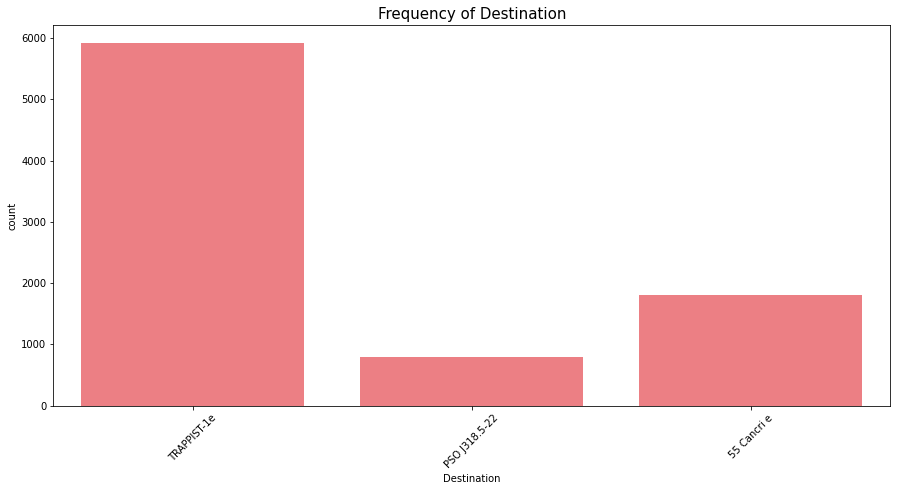

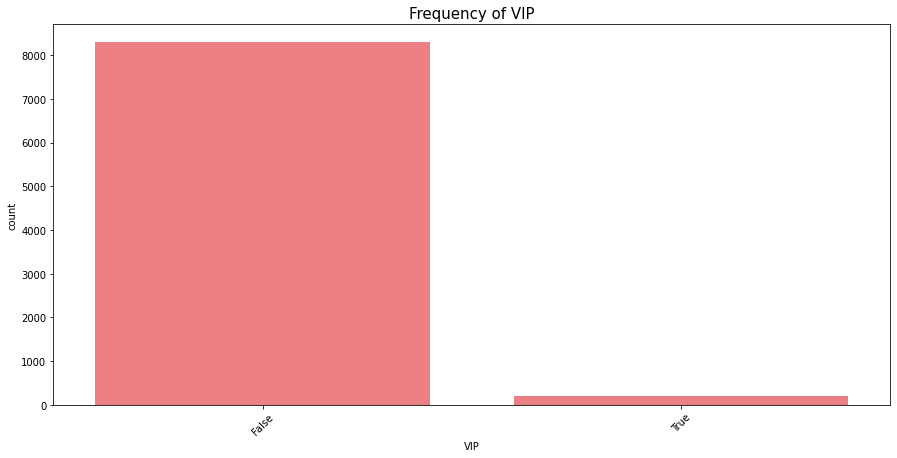

In [10]:
def countplot_features(df_train, feature, title):
    '''Takes a column from the dataframe and plots the distribution (after count).'''    
           
    plt.figure(figsize = (15, 7))
    
    sns.countplot(df_train[feature], color = '#fe6d73')
        
    plt.title(title, fontsize=15)
    plt.xticks(rotation=45)
    plt.show();

# plot distributions of categorical features
for feature in CATEGORICAL_FEATURE_NAMES1:
    fig = countplot_features(df_train, feature=feature, title = "Frequency of "+ feature)

## **<span style="color:#e76f51;">Correlation of Features</span>**

<AxesSubplot:>

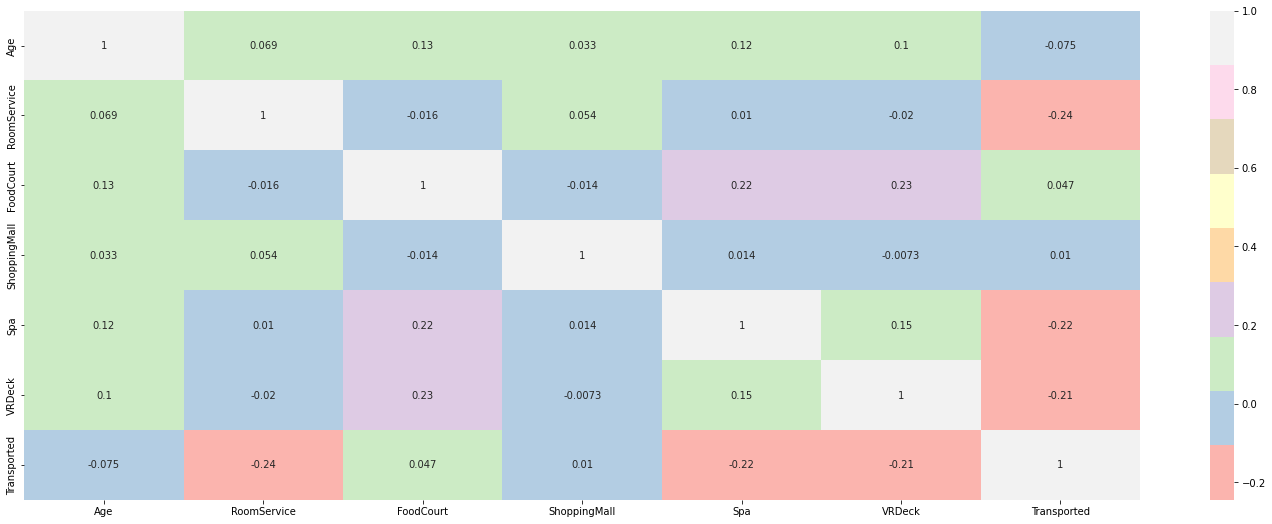

In [11]:
plt.figure(figsize=(25, 9))
sns.heatmap(df_train[[f'{feature}' for feature in df_train.columns]].corr(),annot=True ,cmap = "Pastel1")

# **<span style="color:#e76f51;">Preprocessing</span>**

In [12]:
df_train.drop(['PassengerId', 'Cabin','Name','CryoSleep','VIP'],axis =1 , inplace=True)
df_test.drop(['PassengerId', 'Cabin','Name','CryoSleep','VIP'],axis = 1 ,inplace=True)
df_train.Transported.replace([True,False], ["1", "0"], inplace=True)

In [13]:
df_train["Age"].fillna(df_train["Age"].mean(skipna=True), inplace=True)
df_test["Age"].fillna(df_test["Age"].mean(skipna=True), inplace=True)

df_train["RoomService"].fillna(df_train["RoomService"].mean(skipna=True), inplace=True)
df_test["RoomService"].fillna(df_test["RoomService"].mean(skipna=True), inplace=True)

df_train["FoodCourt"].fillna(df_train["FoodCourt"].mean(skipna=True), inplace=True)
df_test["FoodCourt"].fillna(df_test["FoodCourt"].mean(skipna=True), inplace=True)

df_train["ShoppingMall"].fillna(df_train["ShoppingMall"].mean(skipna=True), inplace=True)
df_test["ShoppingMall"].fillna(df_test["ShoppingMall"].mean(skipna=True), inplace=True)

df_train["Spa"].fillna(df_train["Spa"].mean(skipna=True), inplace=True)
df_test["Spa"].fillna(df_test["Spa"].mean(skipna=True), inplace=True)

df_train["VRDeck"].fillna(df_train["VRDeck"].mean(skipna=True), inplace=True)
df_test["VRDeck"].fillna(df_test["VRDeck"].mean(skipna=True), inplace=True)


df_train["HomePlanet"].fillna('Kepler', inplace=True)
df_test["HomePlanet"].fillna('Kepler', inplace=True)

df_train["Destination"].fillna('TRAPPIST-1e', inplace=True)
df_test["Destination"].fillna('TRAPPIST-1e', inplace=True)

df_train.dropna(inplace = True)
df_test.dropna(inplace = True)

In [14]:
CSV_HEADER = [
    "HomePlanet",
    "Destination",
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "Transported",
    ]

train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

df_train.to_csv(train_data_file, index=False, header=False)
df_test.to_csv(test_data_file, index=False, header=False)

# **<span style="color:#e76f51;">W & B Artifacts</span>**

An artifact as a versioned folder of data.Entire datasets can be directly stored as artifacts .

W&B Artifacts are used for dataset versioning, model versioning . They are also used for tracking dependencies and results across machine learning pipelines.Artifact references can be used to point to data in other systems like S3, GCP, or your own system.

You can learn more about W&B artifacts [here](https://docs.wandb.ai/guides/artifacts)

![](https://drive.google.com/uc?id=1JYSaIMXuEVBheP15xxuaex-32yzxgglV)

In [15]:
# Save train data to W&B Artifacts
run = wandb.init(project='SpaceTitanic', name='training_data', anonymous=anony,config=CONFIG) 
artifact = wandb.Artifact(name='training_data',type='dataset')
artifact.add_file("./train_data.csv")

wandb.log_artifact(artifact)
wandb.finish()

wandb: Currently logged in as: usharengaraju (use `wandb login --relogin` to force relogin)


In [16]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "HomePlanet": sorted(list(df_train["HomePlanet"].unique())),
    "Destination": sorted(list(df_train["Destination"].unique())),
        
}

# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

# The name of the target feature.
TARGET_FEATURE_NAME = "Transported"

# A list of the labels of the target features.
TARGET_LABELS = ["0", "1"]



## **<span style="color:#e76f51;">🎯tf.data</span>**

tf.data API is used for building efficient input pipelines which can handle large amounts of data and perform complex data transformations . tf.data API has provisions for handling different data formats .


## **<span style="color:#e76f51;">🎯tf.data.Dataset</span>**

tf.data.Dataset is an abstraction introduced by tf.data API and consists of sequence of elements where each element has one or more components . For example , in a tabular data pipeline , an element might be a single training example , with a pair of tensor components representing the input features and its label

tf.data.Dataset can be created using two distinct ways

Constructing a dataset using data stored in memory by a data source

Constructing a dataset from one or more tf.data.Dataset objects by a data transformation

In [17]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        shuffle=shuffle
    )
    return dataset.cache()

## **<span style="color:#e76f51;">🎯Model Inputs</span>**

In [18]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

## **<span style="color:#e76f51;">Feature representation using Keras Preprocessing Layers</span>**

Feature representations can be one of the crucial aspect in model developement workflows . It is a experimental process and there is no perfect solution . Keras preprocessing Layers helps us create more flexible preprocessing pipeline where new data transformations can be applied while changing the model architecture .

![](https://drive.google.com/uc?id=1248y8JYTwjnxZnIEaTQHr1xV5jUZotLm)

[ImageSource](https://blog.tensorflow.org/2021/11/an-introduction-to-keras-preprocessing.html)

## **<span style="color:#e76f51;">Keras Preprocessing Layers - Numerical Features</span>**

The Keras preprocessing layers available for numerical features are below 

`tf.keras.layers.Normalization`: performs feature-wise normalization of input features.
  
`tf.keras.layers.Discretization`: turns continuous numerical features into integer categorical features.

`adapt():`

Adapt is an optional utility function which helps in setting the internal state of layers from input data . adapt() is available on all stateful processing layerrs and it computes mean and variance for the layerrs and stores them as layers weights . adapt() is called before fit() , evaluate or predict()


## **<span style="color:#e76f51;">Keras Preprocessing Layers - Categorical Features</span>**

The various keras preprocessing layers available for categorical variables are below .

`tf.keras.layers.CategoryEncoding:` turns integer categorical features into one-hot, multi-hot, or count dense representations.

`tf.keras.layers.Hashing:` performs categorical feature hashing, also known as the "hashing trick".

`tf.keras.layers.StringLookup:` turns string categorical values an encoded representation that can be read by an Embedding layer or Dense layer.

`tf.keras.layers.IntegerLookup:` turns integer categorical values into an encoded representation that can be read by an Embedding layer or Dense layer.

In [19]:
def encode_inputs(inputs):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = lookup(inputs[feature_name])
            embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=lookup.vocabulary_size(), output_dim=embedding_dims
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = inputs[feature_name]
            if inputs[feature_name].shape[-1] is None:
                encoded_feature = tf.expand_dims(encoded_feature, -1)

        encoded_features.append(encoded_feature)

    encoded_features = layers.concatenate(encoded_features)
    return encoded_features

In [20]:
class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super(NeuralDecisionTree, self).__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs

In [21]:
class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super(NeuralDecisionForest, self).__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs

In [22]:
learning_rate = 0.01
batch_size = 265
num_epochs = 10
hidden_units = [64, 64]
num_trees = 25
depth = 5
used_features_rate = 0.5
num_classes = len(TARGET_LABELS)


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    print("Start training the model...")
    train_dataset = get_dataset_from_csv(
        train_data_file, shuffle=True, batch_size=batch_size
    )

    model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

  

In [23]:

def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

forest_model = create_forest_model()
run_experiment(forest_model)


2022-02-24 04:18:01.493926: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Start training the model...


2022-02-24 04:18:03.620531: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
33/33 [==============================] - 19s 26ms/step - loss: 0.6765 - sparse_categorical_accuracy: 0.6699
Epoch 2/10
33/33 [==============================] - 1s 23ms/step - loss: 0.6088 - sparse_categorical_accuracy: 0.7142
Epoch 3/10
33/33 [==============================] - 1s 23ms/step - loss: 0.5513 - sparse_categorical_accuracy: 0.7429
Epoch 4/10
33/33 [==============================] - 1s 24ms/step - loss: 0.5234 - sparse_categorical_accuracy: 0.7582
Epoch 5/10
33/33 [==============================] - 1s 23ms/step - loss: 0.5102 - sparse_categorical_accuracy: 0.7647
Epoch 6/10
33/33 [==============================] - 1s 23ms/step - loss: 0.5028 - sparse_categorical_accuracy: 0.7681
Epoch 7/10
33/33 [==============================] - 1s 23ms/step - loss: 0.4978 - sparse_categorical_accuracy: 0.7728
Epoch 8/10
33/33 [==============================] - 1s 23ms/step - loss: 0.4942 - sparse_categorical_accuracy: 0.7746
Epoch 9/10
33/33 [==============================] - 1s 

# **<span style="color:#F7B2B0;">References</span>**

[Deep Neural Decision Forests](https://github.com/keras-team/keras-io/blob/master/examples/structured_data/deep_neural_decision_forests.py)

# Work in progress 🚧